In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from KoBERT.kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert.utils import get_tokenizer
import numpy as np
from tqdm import tqdm,  tqdm_notebook
import pandas as pd
from torch import nn
from torchcrf import CRF
from transformers import AdamW
from seqeval.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
epochs = 5
num =8
max_len = 256

In [3]:
bertmodel, vocab = get_pytorch_kobert_model() # KoBERT 모델 불러오기
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model
using cached model
using cached model


In [4]:
class KobertCRF(nn.Module):
    """ KoBERT with CRF """
    def __init__(self, bert, hidden_size=768, num_classes=num, dr_rate=0.3, params=None):
        super(KobertCRF, self).__init__()

        self.bert = bert

        self.dropout = nn.Dropout(dr_rate)
        self.position_wise_ff = nn.Linear(hidden_size, num_classes)
        self.crf = CRF(num_tags=num_classes, batch_first = True)
        
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()
        
    def forward(self, input_ids, valid_length, token_type_ids=None, tags=None):
        attention_mask = self.gen_attention_mask(input_ids, valid_length)

        # outputs: (last_encoder_layer, pooled_output, attention_weight)
        outputs = self.bert(input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask.float().to(input_ids.device))
        last_encoder_layer = outputs[0]
        last_encoder_layer = self.dropout(last_encoder_layer)
        emissions = self.position_wise_ff(last_encoder_layer)

        if tags is not None:
            log_likelihood, sequence_of_tags = self.crf(emissions, tags), self.crf.decode(emissions)
            return log_likelihood, sequence_of_tags
        else:
            sequence_of_tags = self.crf.decode(emissions)
            return sequence_of_tags

In [5]:
label_dict = {'O': 0,
 'UNK':1,
 'PDT-B': 2,
 'PDT-I': 3,
 'MOV-B': 4,
 'MOV-I': 5,
 'TRV-B': 6,
 'TRV-I': 7}

In [6]:
train_list_csv = pd.read_csv('train_data.tsv',delimiter='\t')
test_list_csv = pd.read_csv('test_data.tsv',delimiter='\t')

train_list_csv = train_list_csv.dropna(axis=0)
test_list_csv = test_list_csv.dropna(axis=0)

train_list_csv = train_list_csv.reset_index(drop=True)
test_list_csv = test_list_csv.reset_index(drop=True)

for i in range(len(train_list_csv['label'])):
    train_list_csv['label'][i] = train_list_csv['label'][i][1:-1].replace('\'','').replace(' ','').split(",")
for i in range(len(test_list_csv['label'])):
    test_list_csv['label'][i] = test_list_csv['label'][i][1:-1].replace('\'','').replace(' ','').split(",")


for i in range(len(train_list_csv['label'])):
    text_split = train_list_csv['text'][i].split()
    ex_label = []
    for j in range(len(train_list_csv['label'][i])):
        ex_label.append(label_dict[train_list_csv['label'][i][j]])
    train_list_csv['label'][i]=ex_label

for i in range(len(test_list_csv['label'])):
    text_split = test_list_csv['text'][i].split()
    ex_label = []
    for j in range(len(test_list_csv['label'][i])):
        ex_label.append(label_dict[test_list_csv['label'][i][j]])
    test_list_csv['label'][i]=ex_label

tr_tag = train_list_csv['label']
tr_sent = train_list_csv['text']
ts_tag = test_list_csv['label']
ts_sent = test_list_csv['text']

len(tr_tag), len(tr_sent), len(ts_tag), len(ts_sent)

(18390, 18390, 4599, 4599)

In [7]:
for i in range(len(tr_tag)):
    if len(tr_tag[i]) > max_len or len(tr_sent[i]) > max_len: # 문장의 길이가 512가 넘는 문장 제거
        del tr_sent[i]
        del tr_tag[i]

for i in range(len(ts_tag)):
    if len(ts_tag[i]) > max_len or len(ts_sent[i]) > max_len: # 문장의 길이가 512가 넘는 문장 제거
        del ts_sent[i]
        del ts_tag[i]

tr_sent = tr_sent.reset_index(drop=True)
tr_tag = tr_tag.reset_index(drop=True)

ts_sent = ts_sent.reset_index(drop=True)
ts_tag = ts_tag.reset_index(drop=True)

len(tr_tag), len(tr_sent), len(ts_tag), len(ts_sent)

(18029, 18029, 4514, 4514)

In [8]:
def make_label_token(sent, label):
    label_list = [1]
    sent_split = sent.split()
    for i in range(len(sent_split)):
        sent_tok = tok(sent_split[i])
        if label[i] !=0 and label[i]%2==0:
            label_list.append(label[i])
            for j in sent_tok[1:]:
                label_list.append(label[i]+1)
        else: 
            for j in sent_tok:
                label_list.append(label[i])
    label_list.append(1)
    
    return label_list

In [9]:
tr_label = []
ts_label = []

for i,j in zip(tr_sent, tr_tag):
    tr_label.append(make_label_token(i,j))

for i,j in zip(ts_sent, ts_tag):
    ts_label.append(make_label_token(i,j))

len(tr_label), len(tr_sent), len(ts_label), len(ts_sent)

(18029, 18029, 4514, 4514)

In [10]:
for i in range(len(tr_label)):
    padding_length = max_len - len(tr_label[i])
    tr_label[i] = np.array(tr_label[i] + ([1] * padding_length))
    tr_label[i] =tr_label[i].astype(np.int64) 

for i in range(len(ts_label)):
    padding_length = max_len - len(ts_label[i])
    ts_label[i] = np.array(ts_label[i] + ([1] * padding_length))
    ts_label[i] =ts_label[i].astype(np.int64) 

len(tr_label), len(tr_sent), len(ts_label), len(ts_sent)

(18029, 18029, 4514, 4514)

In [11]:
class BERTDataset(Dataset):
    def __init__(self, sent, tag, bert_tokenizer, max_len,
                pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_len, pad=pad, pair=pair)
        self.sentences = [transform([i]) for i in sent] #문장
        self.labels = tag

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [12]:
train_data = pd.DataFrame([tr_sent.tolist(),tr_label]).T
test_data =  pd.DataFrame([ts_sent.tolist(),ts_label]).T

In [13]:
data_train = BERTDataset(tr_sent,tr_label, tok, max_len, True, False)
data_test = BERTDataset(ts_sent,ts_label, tok, max_len, True, False)

In [14]:
train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=True)

In [15]:
def count_len(list):
    count = 0
    for i in range(len(list)):
        if list[i] == 1:
            break
        else:
            count += 1
    return count

In [ ]:
data_tr_count = 0
data_ts_count = 0
for i in tqdm_notebook(range(len(data_train))): 
    if count_len(data_train[i][0]) != count_len(data_train[i][3][1:])+2:
        data_tr_count += 1
        print(i)

for i in tqdm_notebook(range(len(data_test))):
    if count_len(data_test[i][0]) != count_len(data_test[i][3][1:])+2:
        data_ts_count += 1
        print(i)
print(data_tr_count, data_ts_count)

In [17]:
device = torch.device('cuda:0')
model = KobertCRF(bertmodel, num_classes=num)
model.to(device)

KobertCRF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [18]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [19]:
label_list = ['O','[UNK]','PDT-B','PDT-I','MOV-B','MOV-I','TRV-B','TRV-I']

In [20]:
def compute_f1_pre_rec(labels, preds):

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, suffix=True),
        "recall": recall_score(labels, preds, suffix=True),
        "f1": f1_score(labels, preds, suffix=True)
    }

def show_report(labels, preds):
    return classification_report(labels, preds, suffix=True,digits=4)

def F1Metrics(y_true, y_pred):

    results = {}

    pred_argmax = y_pred
    label = np.array(y_true)

    slot_label_map = {i: label for i, label in enumerate(label_list)}

    out_label_list = [[] for _ in range(label.shape[0])]
    preds_list = [[] for _ in range(label.shape[0])]

    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            if label[i, j] != 1:
                out_label_list[i].append(slot_label_map[label[i][j]])
                if pred_argmax[i][j] ==1:
                    pred_argmax[i][j]=0
                preds_list[i].append(slot_label_map[pred_argmax[i][j]])

    result = compute_f1_pre_rec(out_label_list, preds_list)
    results.update(result)

    print("********")
    print("F1 Score")
    for key in sorted(results.keys()):
        print("{}, {:.4f}".format(key, results[key]))
    print("\n" + show_report(out_label_list, preds_list))
    print("********")

    return f1_score(out_label_list, preds_list, suffix=True)

In [ ]:
max = 0.0

for i in range(epochs):
  model.train()
  y_pred = []
  y_true = []

  for input_ids_batch, valid_length_batch, segment_ids_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    log_likelihood, sequence_of_tags = model(input_ids_batch.to(device), valid_length_batch.to(device), tags=y_batch)
    loss = -1 * log_likelihood
    loss.backward()
    optimizer.step()

    total_loss = loss.item()
    y_batch = y_batch.cpu().tolist()

    y_pred.extend(sequence_of_tags)
    y_true.extend(y_batch)

  F1Metrics(y_true,y_pred) 

torch.save(model,"kobert_crf")


In [ ]:
model.eval()
y_pred_test = []
y_true_test = []

with torch.no_grad():
    for input_ids_batch_test, valid_length_test, segment_ids_test, y_batch_test in tqdm(test_loader):
        y_batch_test = y_batch_test.to(device)
        sequence_of_tags_test = model(input_ids_batch_test.to(device), valid_length_test.to(device))

        y_batch_test = y_batch_test.cpu().tolist()

        y_pred_test.extend(sequence_of_tags_test)
        y_true_test.extend(y_batch_test)

    print("epoch: "+str(i+1)+"/"+str(epochs))
    f1 = F1Metrics(y_true_test,y_pred_test)
    f1 = float(f1)

In [21]:
model = torch.load("kobert_crf")

In [22]:
model.eval()
y_pred_test = []
y_true_test = []

for input_ids_batch_test, valid_length_test, segment_ids_test, y_batch_test in tqdm(test_loader):
    y_batch_test = y_batch_test.to(device)
    sequence_of_tags_test = model(input_ids_batch_test.to(device), valid_length_test.to(device))

    y_batch_test = y_batch_test.cpu().tolist()

    y_pred_test.extend(sequence_of_tags_test)
    y_true_test.extend(y_batch_test)

F1Metrics(y_true_test,y_pred_test)

  0%|          | 0/333 [00:00<?, ?it/s]C:\Users\user\anaconda3\lib\site-packages\torchcrf\__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:255.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 333/333 [01:48<00:00,  3.08it/s]


********
F1 Score
accuracy, 0.8775
f1, 0.5231
precision, 0.4943
recall, 0.5553

              precision    recall  f1-score   support

         MOV     0.3810    0.4393    0.4081      1104
         PDT     0.6053    0.6494    0.6266      2128
         TRV     0.2778    0.3665    0.3160       382

   micro avg     0.4943    0.5553    0.5231      3614
   macro avg     0.4214    0.4851    0.4502      3614
weighted avg     0.5022    0.5553    0.5270      3614

********


0.523064894448788

In [28]:
label = ['O','[UNK]','PDT-B','PDT-I','MOV-B','MOV-I','TRV-B','TRV-I']

In [24]:
def F1Metrics(y_true, y_pred):
    pred_argmax = y_pred
    label = np.array(y_true)

    slot_label_map = {i: label for i, label in enumerate(label_list)}

    out_label_list = [[] for _ in range(label.shape[0])]
    preds_list = [[] for _ in range(label.shape[0])]

    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            if label[i, j] != 1:
                out_label_list[i].append(slot_label_map[label[i][j]])
                if pred_argmax[i][j] ==1:
                    pred_argmax[i][j]=0
                preds_list[i].append(slot_label_map[pred_argmax[i][j]])
    
    return out_label_list, preds_list

In [25]:
y_true_test, y_pred_test = F1Metrics(y_true_test, y_pred_test)

In [40]:
confusion_sum = [[0 for col in range(len(label))] for row in range(len(label))]

In [41]:
from sklearn.metrics import confusion_matrix

for i in range(len(y_true_test)):
    confusion_sum += confusion_matrix(y_true_test[i], y_pred_test[i], labels=label)

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
confusion_sum = np.delete(confusion_sum, 1, axis = 0)
confusion_sum = np.delete(confusion_sum, 1, axis = 1)

In [44]:
confusion_sum

array([[79801,   439,  2657,   320,  2067,    87,   629],
       [  431,  1618,   110,     7,     1,    25,     1],
       [ 2536,   182, 10107,     1,    46,     1,   119],
       [  277,    21,     4,   617,   102,     4,     1],
       [ 1933,    12,   219,   148,  5404,     0,    30],
       [  138,    27,     2,     8,     1,   150,    23],
       [ 1176,    10,   234,     4,   105,    24,  1297]], dtype=int64)

In [45]:
label = ['O','PDT-B','PDT-I','MOV-B','MOV-I','TRV-B','TRV-I']

In [46]:
import sklearn
from sklearn.preprocessing import *

confusion_sum=MinMaxScaler().fit_transform(confusion_sum.T)

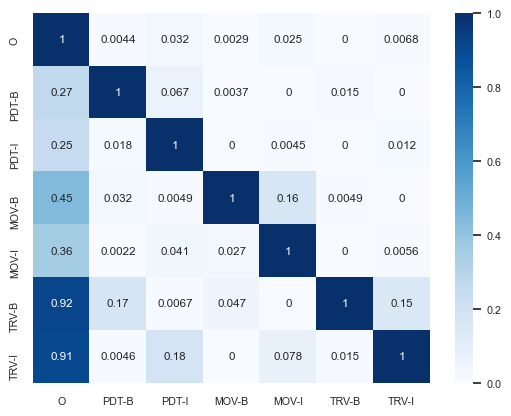

In [47]:
sns.heatmap(confusion_sum.T, annot=True,cmap='Blues',xticklabels=label, yticklabels=label) #숫자 출력
sns.set(font_scale=0.7)
plt.show()  